In [3]:
!pip install -q osmnx geopandas pandas matplotlib

In [24]:
#Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np

# reproducible
np.random.seed(42)  

In [4]:
# Load from GeoPackage
gdf = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="country")
counties = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="counties")

# Load CSV of counties
counties_csv = pd.read_csv("/kaggle/input/counties-data/kenya_counties.csv")

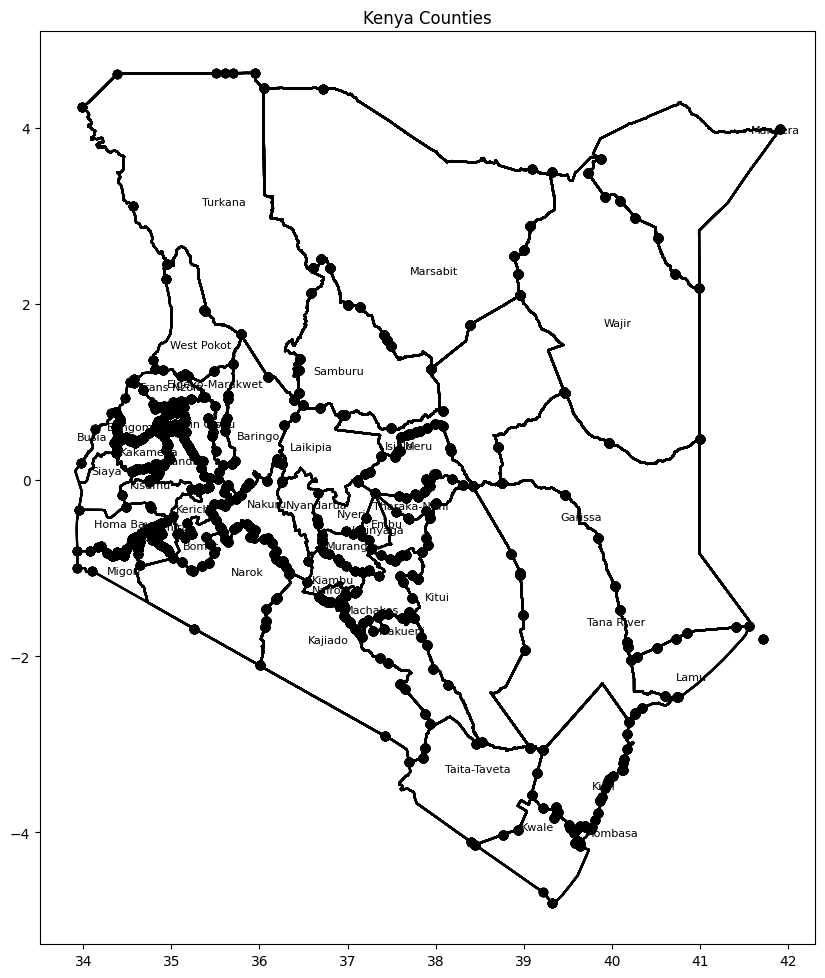

In [8]:
#Get Kenya polygon
kenya_poly = gdf.iloc[0].geometry

#add county boundaries (not sure if this is working right)
counties = gpd.clip(counties, kenya_poly)
# Plot counties
fig, ax = plt.subplots(figsize=(10, 12))
counties.boundary.plot(ax=ax, color="black")

# Overlay centroid labels from CSV
for _, row in counties_csv.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["County"], fontsize=8, ha="center")

ax.set_title("Kenya Counties")
plt.show()

In [12]:
# get admin boundaries overlapping Kenya
tags = {"boundary": "administrative"}
gdf_admin = ox.features_from_polygon(kenya_poly, tags)

/usr/local/lib/python3.11/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 291 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [14]:
# keep only counties (admin_level=4)
gdf_counties = gdf_admin[gdf_admin["admin_level"] == "4"].copy()

'''
1. Filter only Kenyan counties

Many Kenyan counties in OSM have an ISO3166-2 code like KE-xx.
So you can drop anything that doesn’t start with KE-.
'''
if "ISO3166-2" in gdf_counties.columns:
    gdf_counties = gdf_counties[gdf_counties["ISO3166-2"].str.startswith("KE-", na=False)]

# clean up labels

# Use name:en (English) if available, else fall back to name or official_name.

if "name:en" in gdf_counties.columns:
    gdf_counties["label"] = (
        gdf_counties["name:en"]
        .fillna(gdf_counties["name"])
        .fillna(gdf_counties["official_name"])
    )
else:
    gdf_counties["label"] = gdf_counties["name"]

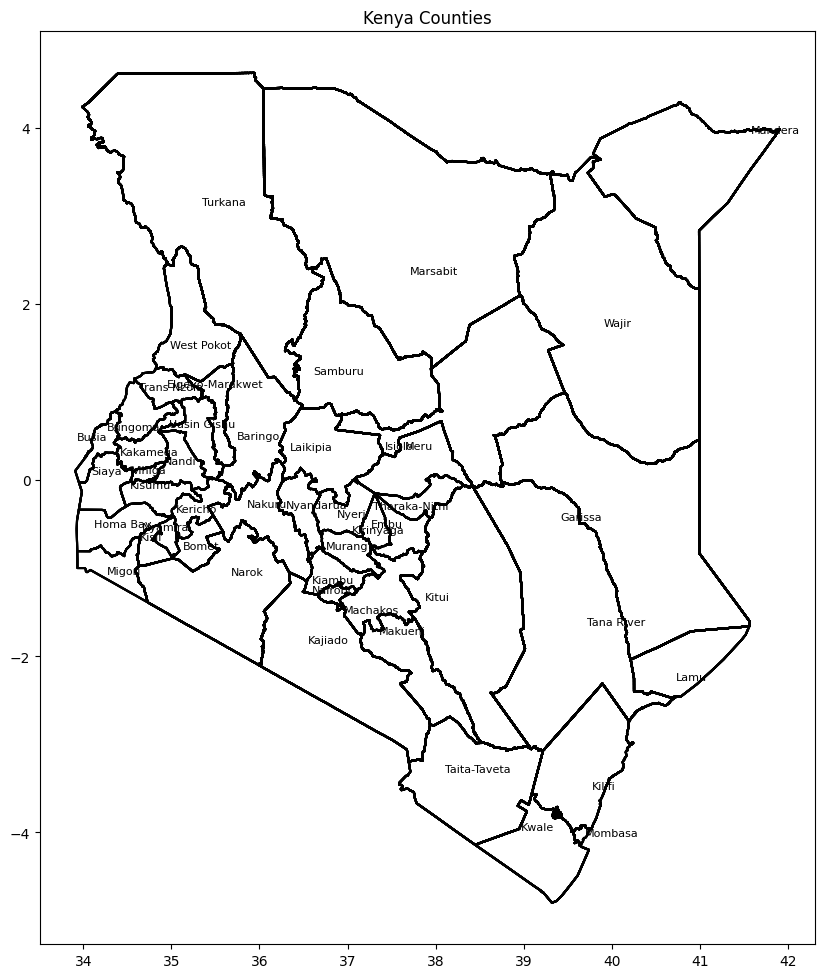

In [15]:
# Plot counties
fig, ax = plt.subplots(figsize=(10, 12))
gdf_counties.boundary.plot(ax=ax, color="black")

# Overlay centroid labels from CSV
for _, row in counties_csv.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["County"], fontsize=8, ha="center")

ax.set_title("Kenya Counties")
plt.show()

In [20]:
# Ensure county names are clean on both sides
counties["name"] = counties["name"].str.strip().str.title()

# Merge CSV with OSMnx data
counties_merged = gdf_counties.merge(counties_csv, left_on="name", right_on="County", how="left")

# Now counties_merged has both geometries + centroid info
#save counties merged.

<Axes: >

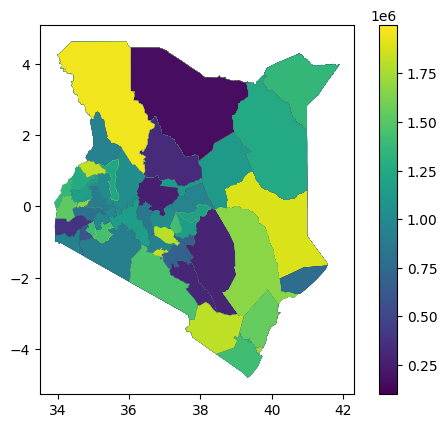

In [27]:
# Add fake population column
counties_merged['population'] = np.random.randint(100_000, 2_000_000, size=len(counties_merged)) #(np.random.lognormal(mean=12, sigma=0.5, size=len(counties_merged)) / 1e3).astype(int) #
counties_merged.plot(column="population", legend=True)